# Time Series Analysis of NVIDIA Stock Prices (1999-2025)


In [1]:
# Install required packages if needed
# install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
#                   "lubridate", "gridExtra", "MASS", "knitr", "lawstat",
#                   "FinTS", "ggthemes"))


In [2]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(forecast)
  library(tseries)
  library(dplyr)
  library(lubridate)
  library(gridExtra)
  library(MASS)
  library(knitr)
  library(lawstat)
  library(FinTS)
  library(TSA)
})


In [3]:
# Plot settings
options(repr.plot.width = 20, repr.plot.height = 10)
theme_tsa <- function() {
  theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "bottom",
      panel.grid.minor = element_line(color = "gray90"),
      panel.grid.major = element_line(color = "gray85")
    )
}


In [4]:
# loading the data and checking it for missing values
# and summary statistics, then printing the results

nvidia_df <- read.csv("../data/nvidia_close_price.csv")

nvidia_df$Date <- as.Date(nvidia_df$Date)

cat("Dataset summary:\n")
print(summary(nvidia_df))

cat(
    "\nDate range:", format(min(nvidia_df$Date), "%Y-%m-%d"),
    "to", format(max(nvidia_df$Date), "%Y-%m-%d"), "\n"
)

cat(
    "Price range:", min(nvidia_df$Price),
    "to", max(nvidia_df$Price), "USD\n"
)

missing_values <- colSums(is.na(nvidia_df))
cat("\nMissing values by column:\n")
print(missing_values)


Dataset summary:
      Date                Price          
 Min.   :1999-01-22   Min.   :  0.03128  
 1st Qu.:2005-08-09   1st Qu.:  0.25882  
 Median :2012-02-22   Median :  0.43829  
 Mean   :2012-02-22   Mean   :  9.24397  
 3rd Qu.:2018-09-06   3rd Qu.:  4.71775  
 Max.   :2025-03-27   Max.   :149.41624  

Date range: 1999-01-22 to 2025-03-27 
Price range: 0.03128349 to 149.4162 USD

Missing values by column:
 Date Price 
    0     0 


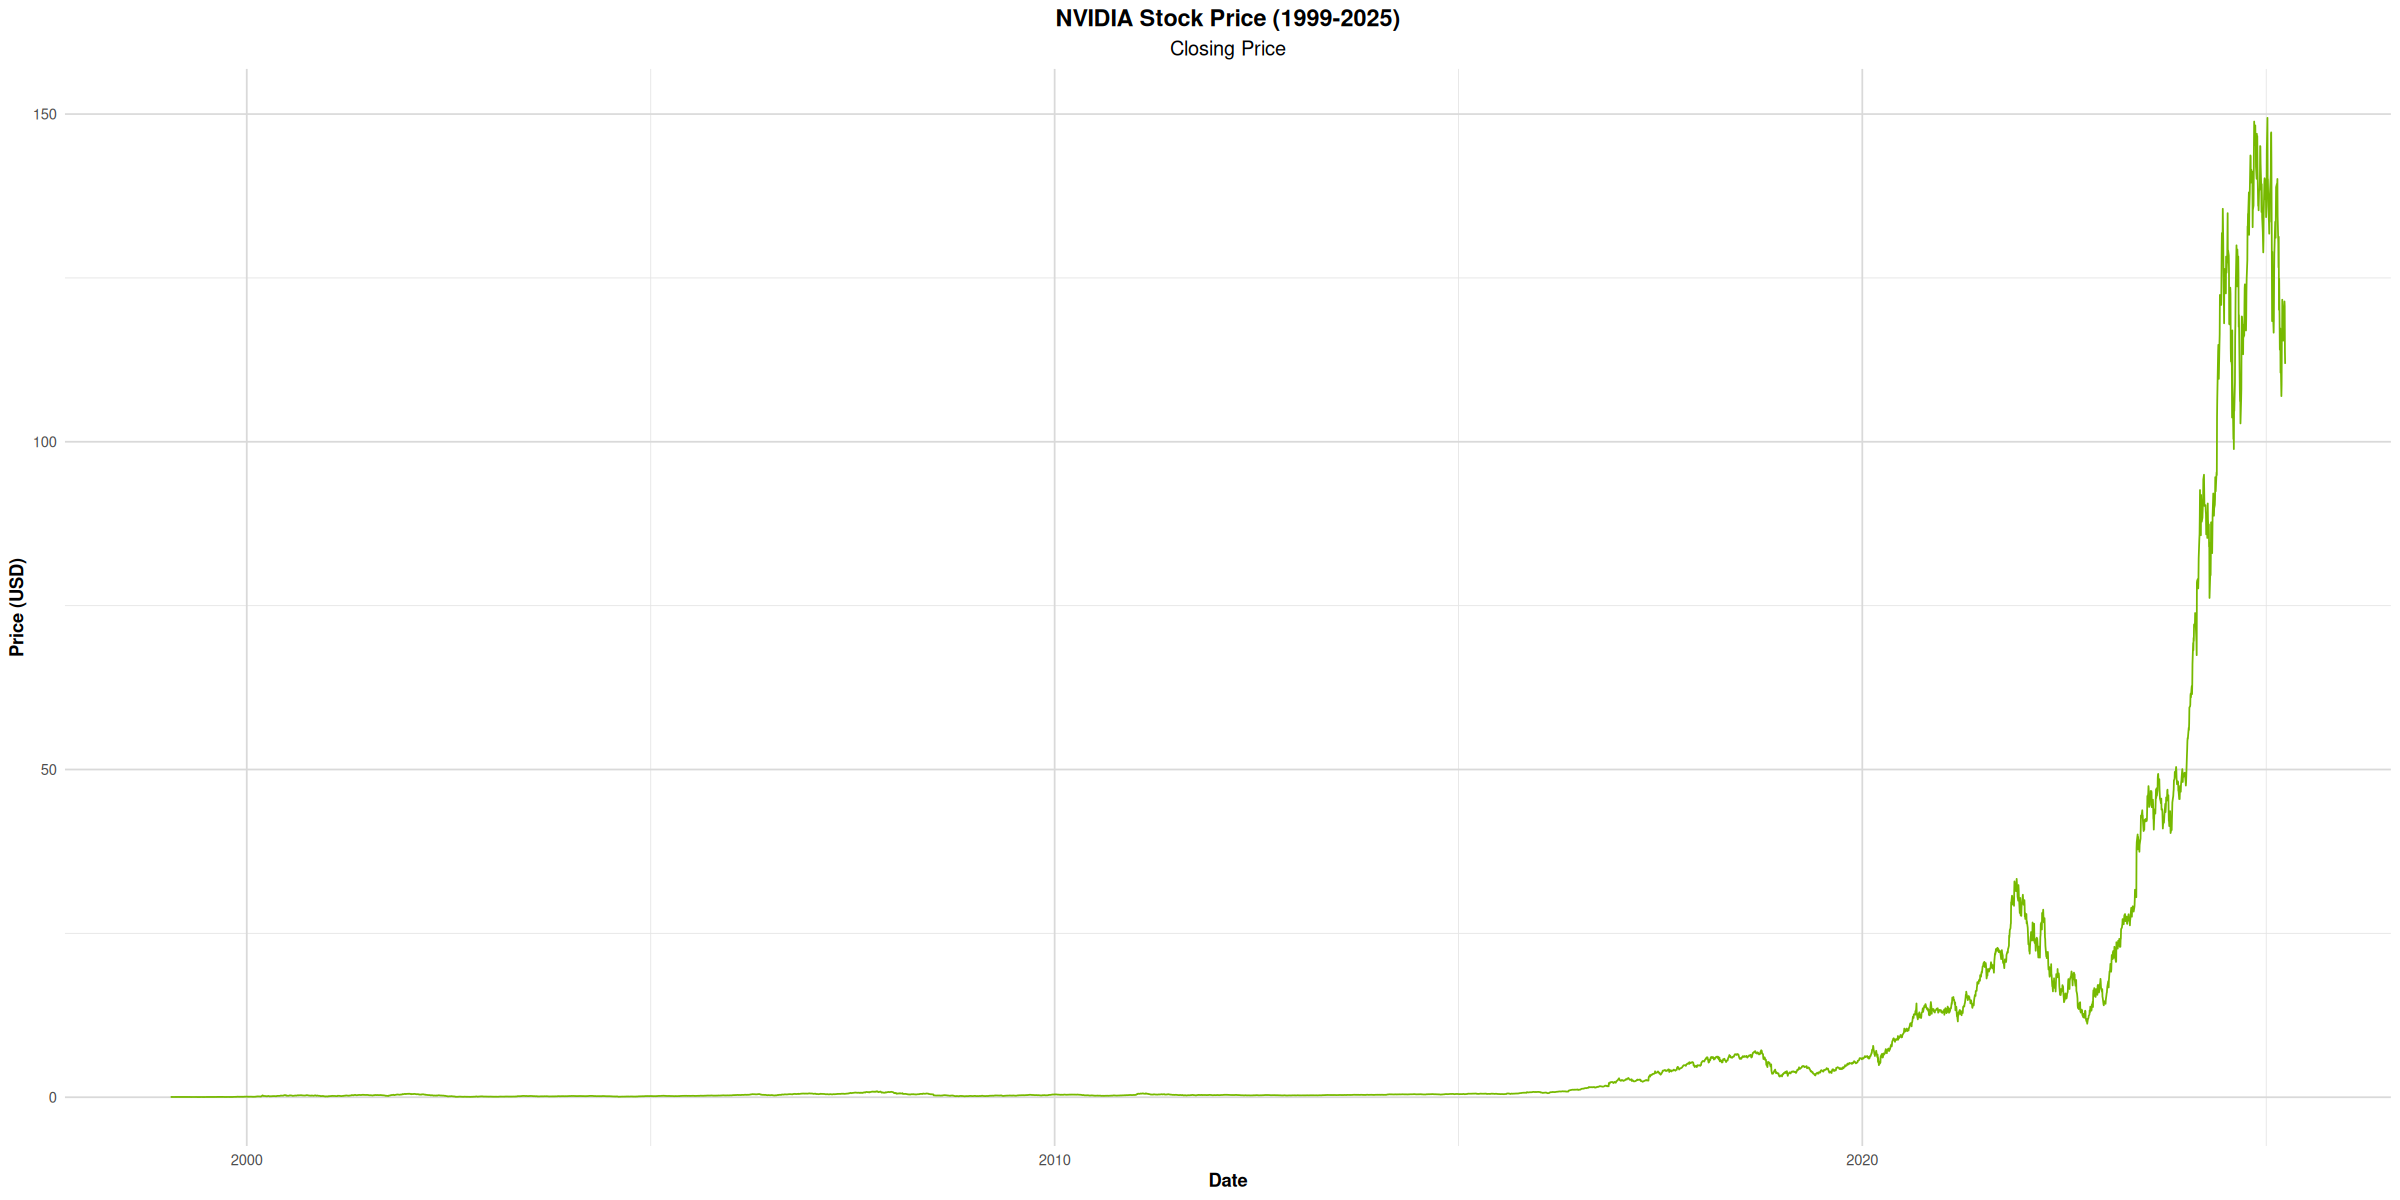

In [5]:
# plot the series

p1 <- ggplot(nvidia_df, aes(x = Date, y = Price)) +
  geom_line(color = "#76B900") +
  labs(
    title = "NVIDIA Stock Price (1999-2025)",
    subtitle = "Closing Price",
    x = "Date",
    y = "Price (USD)"
  ) +
  theme_tsa()

print(p1)


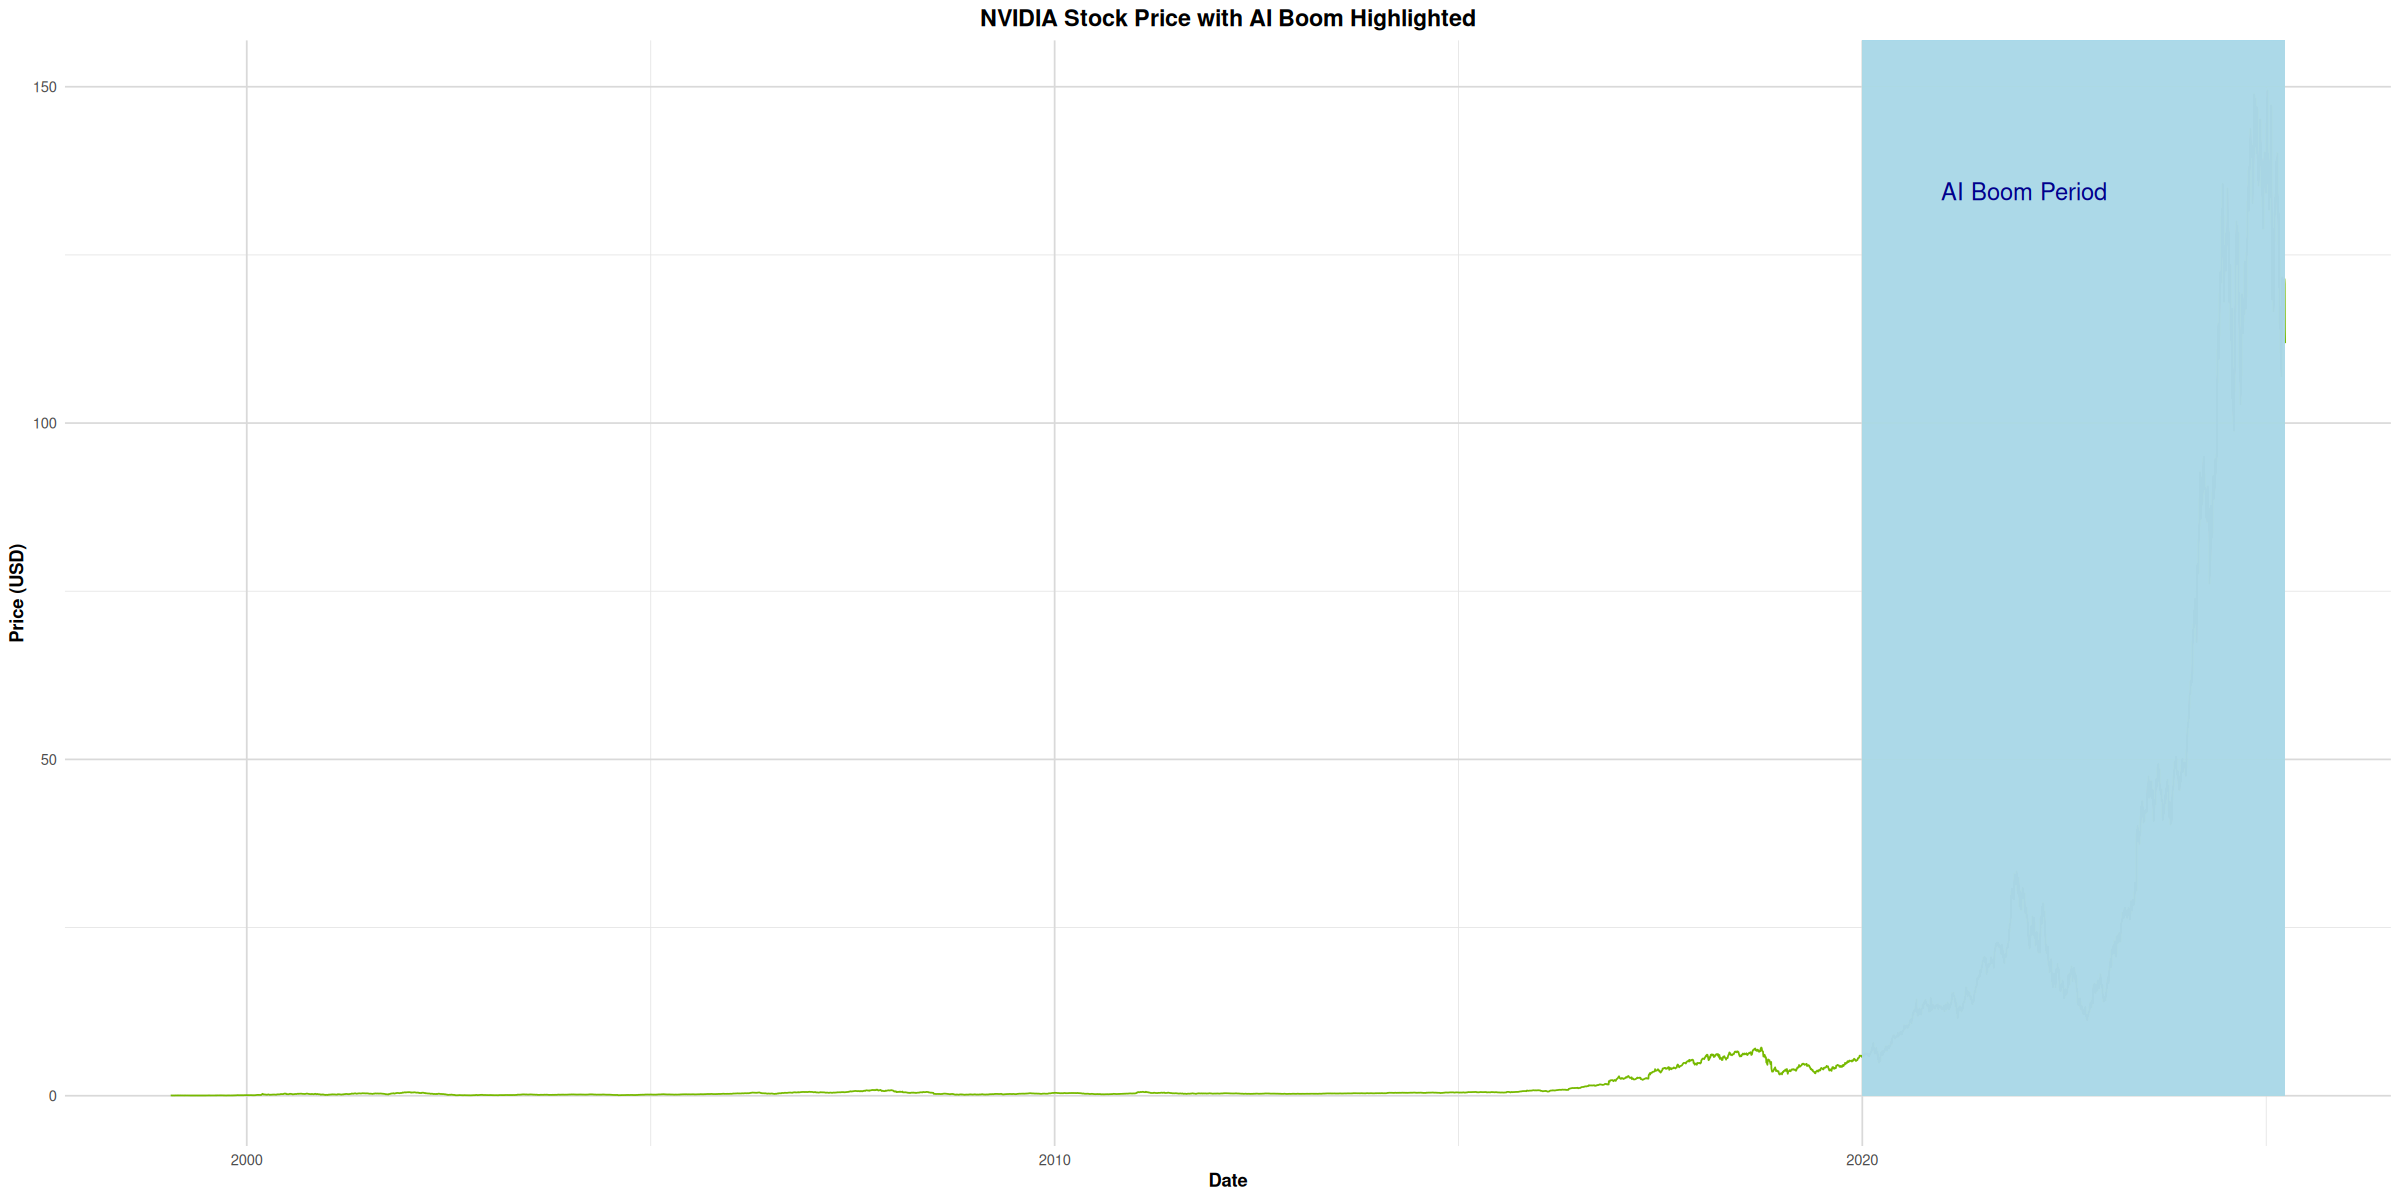

In [6]:
p2 <- ggplot(nvidia_df, aes(x = Date, y = Price)) +
  geom_line(color = "#76B900") +
  geom_rect(
    aes(
      xmin = as.Date("2020-01-01"),
      xmax = max(Date),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightblue", alpha = 0.2
  ) +
  annotate("text",
    x = as.Date("2022-01-01"), y = max(nvidia_df$Price) * 0.9,
    label = "AI Boom Period", color = "darkblue", size = 5
  ) +
  labs(
    title = "NVIDIA Stock Price with AI Boom Highlighted",
    x = "Date",
    y = "Price (USD)"
  ) +
  theme_tsa()

print(p2)


In [7]:
# extracting monthly data for easier analysis
# and create a time series object
nvidia_df$YearMonth <- format(nvidia_df$Date, "%Y-%m")

monthly_data <- nvidia_df %>%
  group_by(YearMonth) %>%
  summarize(
    Date = last(Date),
    Price = last(Price)
  ) %>%
  arrange(Date)

monthly_ts <- ts(monthly_data$Price,
  frequency = 12,
  start = c(
    year(min(monthly_data$Date)),
    month(min(monthly_data$Date))
  )
)


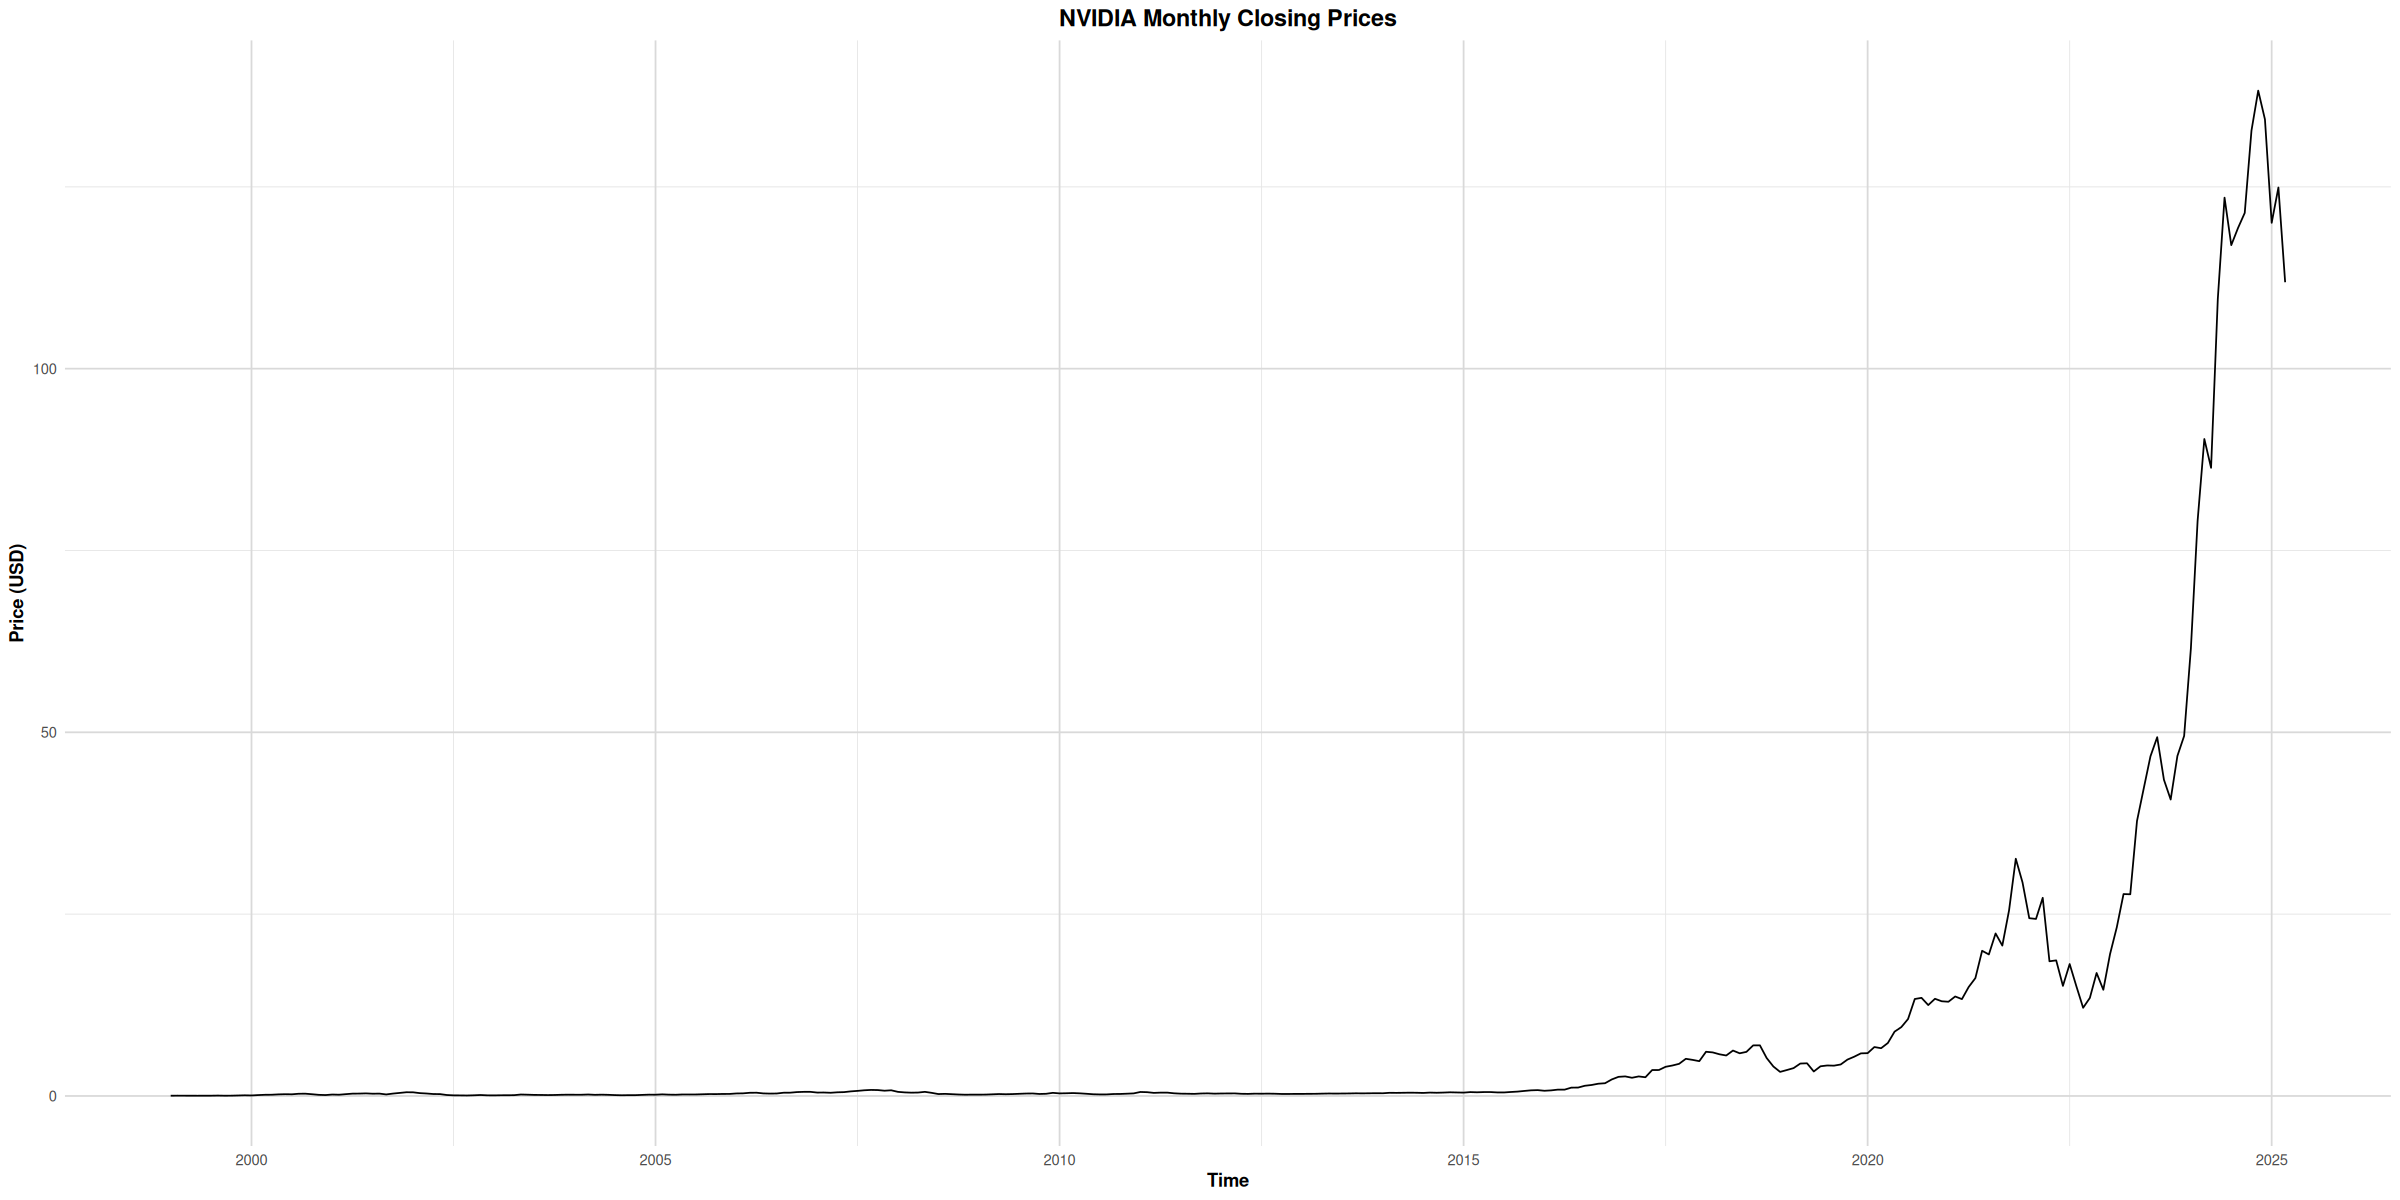

In [8]:
# plot the monthly series

autoplot(monthly_ts) +
  labs(
    title = "NVIDIA Monthly Closing Prices",
    x = "Time",
    y = "Price (USD)"
  ) +
  theme_tsa()


Optimal lambda for Box-Cox transformation: 0.08811436 
Lambda is close to 0, using log transformation


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


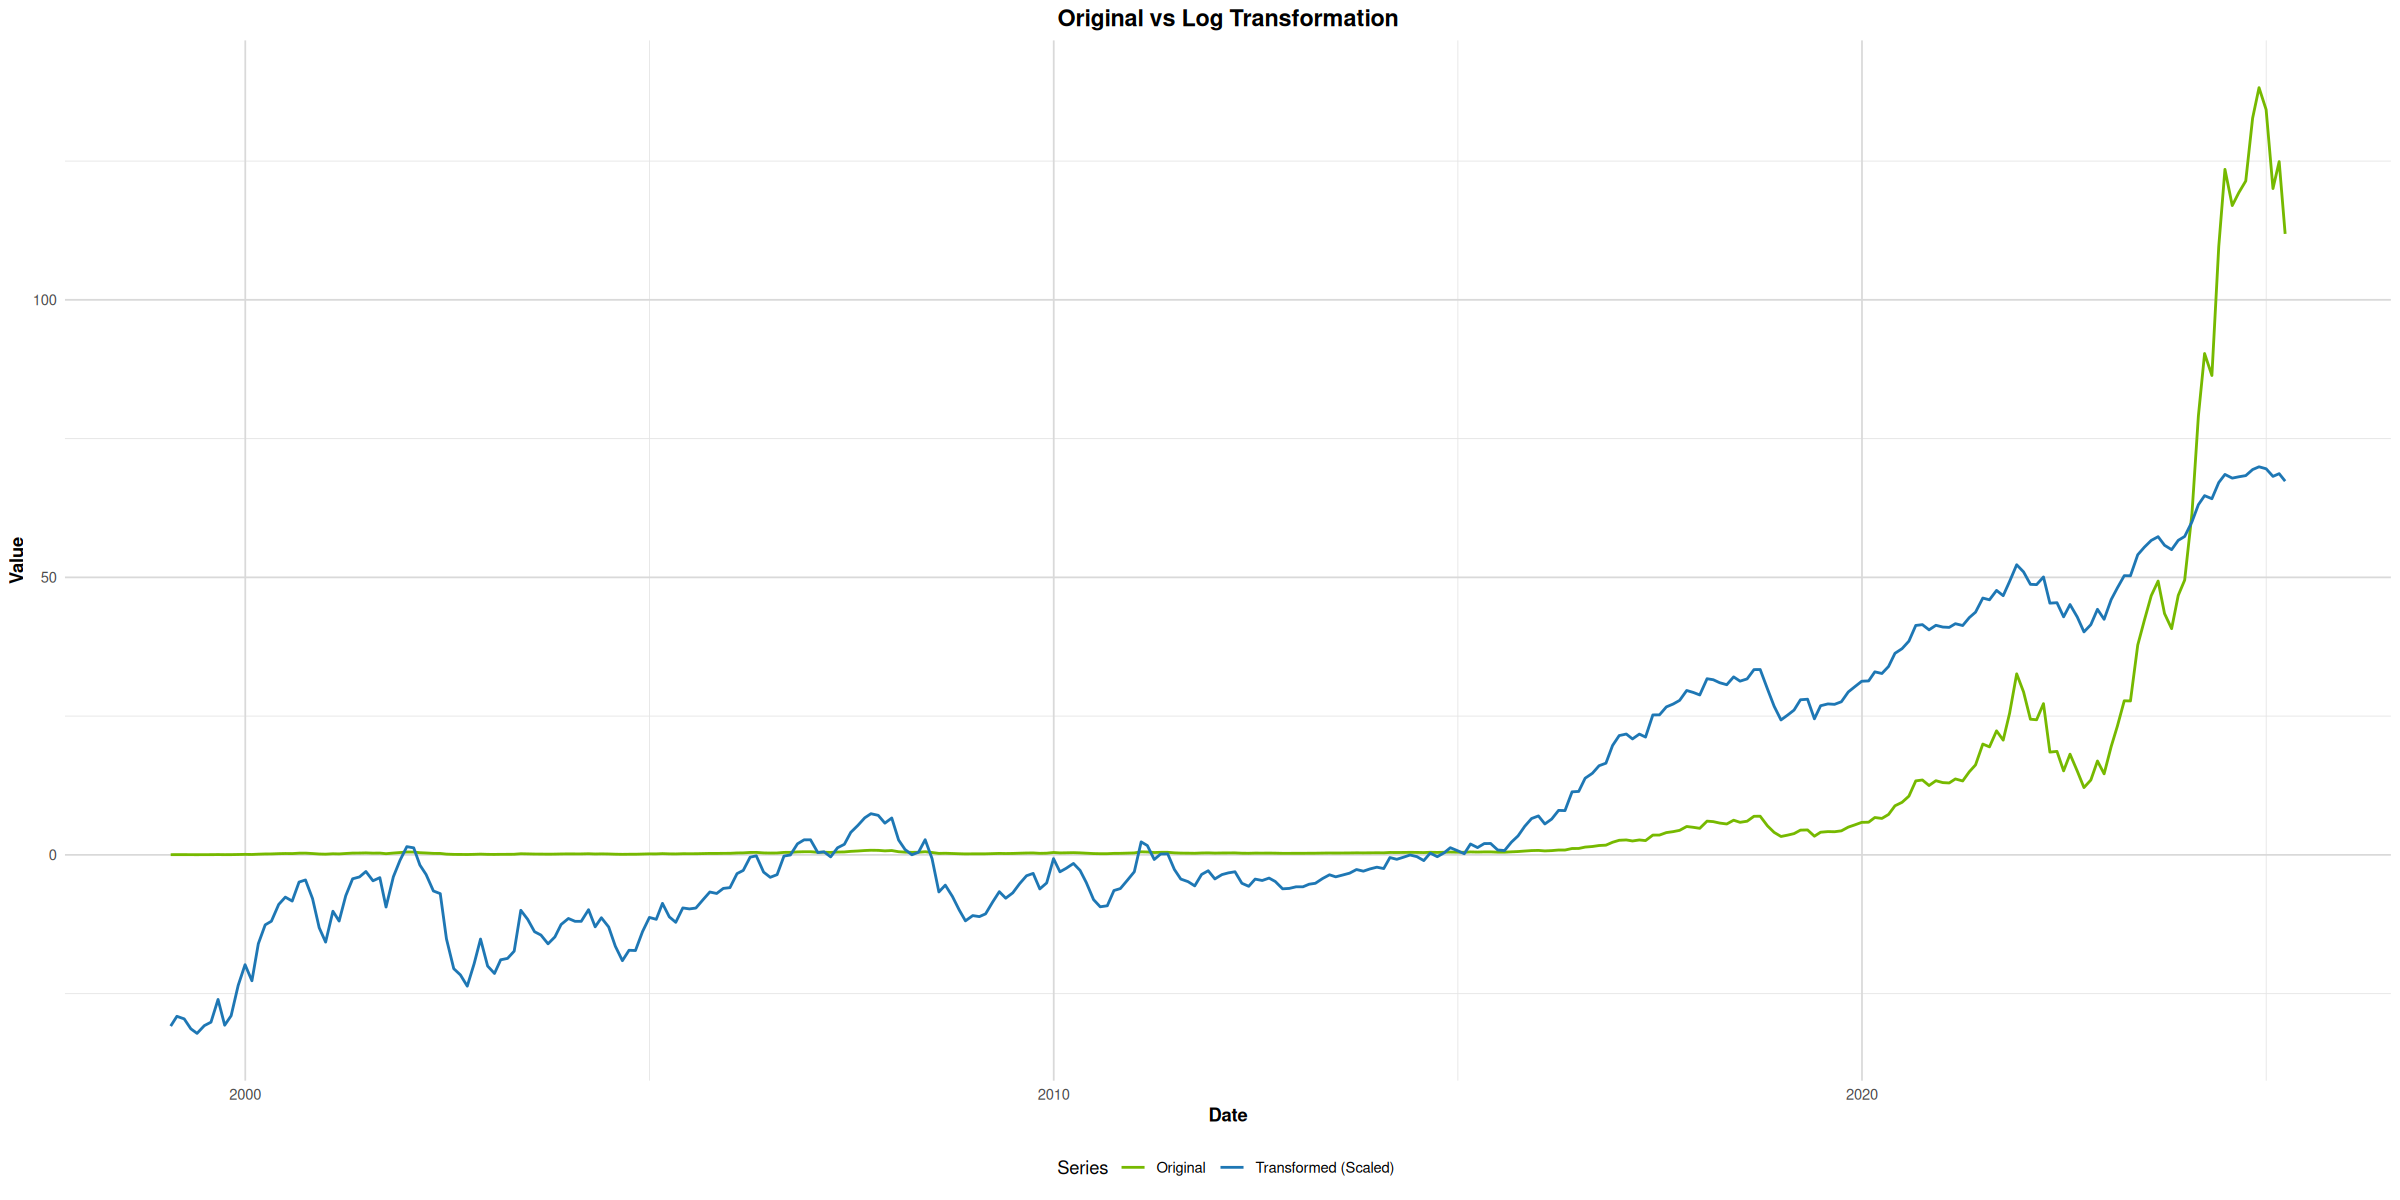

In [9]:
# box-cox transformation

lambda <- BoxCox.lambda(monthly_ts)
cat("Optimal lambda for Box-Cox transformation:", lambda, "\n")
if (abs(lambda) < 0.1) {
    cat("Lambda is close to 0, using log transformation\n")
    transformed_ts <- log(monthly_ts)
    transformation_label <- "Log Transformation"
} else {
    cat("Using Box-Cox transformation with lambda =", lambda, "\n")
    transformed_ts <- BoxCox(monthly_ts, lambda)
    transformation_label <- paste("Box-Cox Transformation (λ =", round(lambda, 4), ")")
}


transformed_df <- data.frame(
    Date = monthly_data$Date,
    Original = as.numeric(monthly_ts),
    Transformed = as.numeric(transformed_ts)
)

p_trans <- ggplot(transformed_df, aes(x = Date)) +
    geom_line(aes(y = Original, color = "Original"), size = 0.8) +
    geom_line(aes(
        y = scale(Transformed) * sd(Original) + mean(Original),
        color = "Transformed (Scaled)"
    ), size = 0.8) +
    labs(
        title = paste("Original vs", transformation_label),
        x = "Date", y = "Value",
        color = "Series"
    ) +
    scale_color_manual(values = c("Original" = "#76B900", "Transformed (Scaled)" = "#1E77B4")) +
    theme_tsa()

print(p_trans)


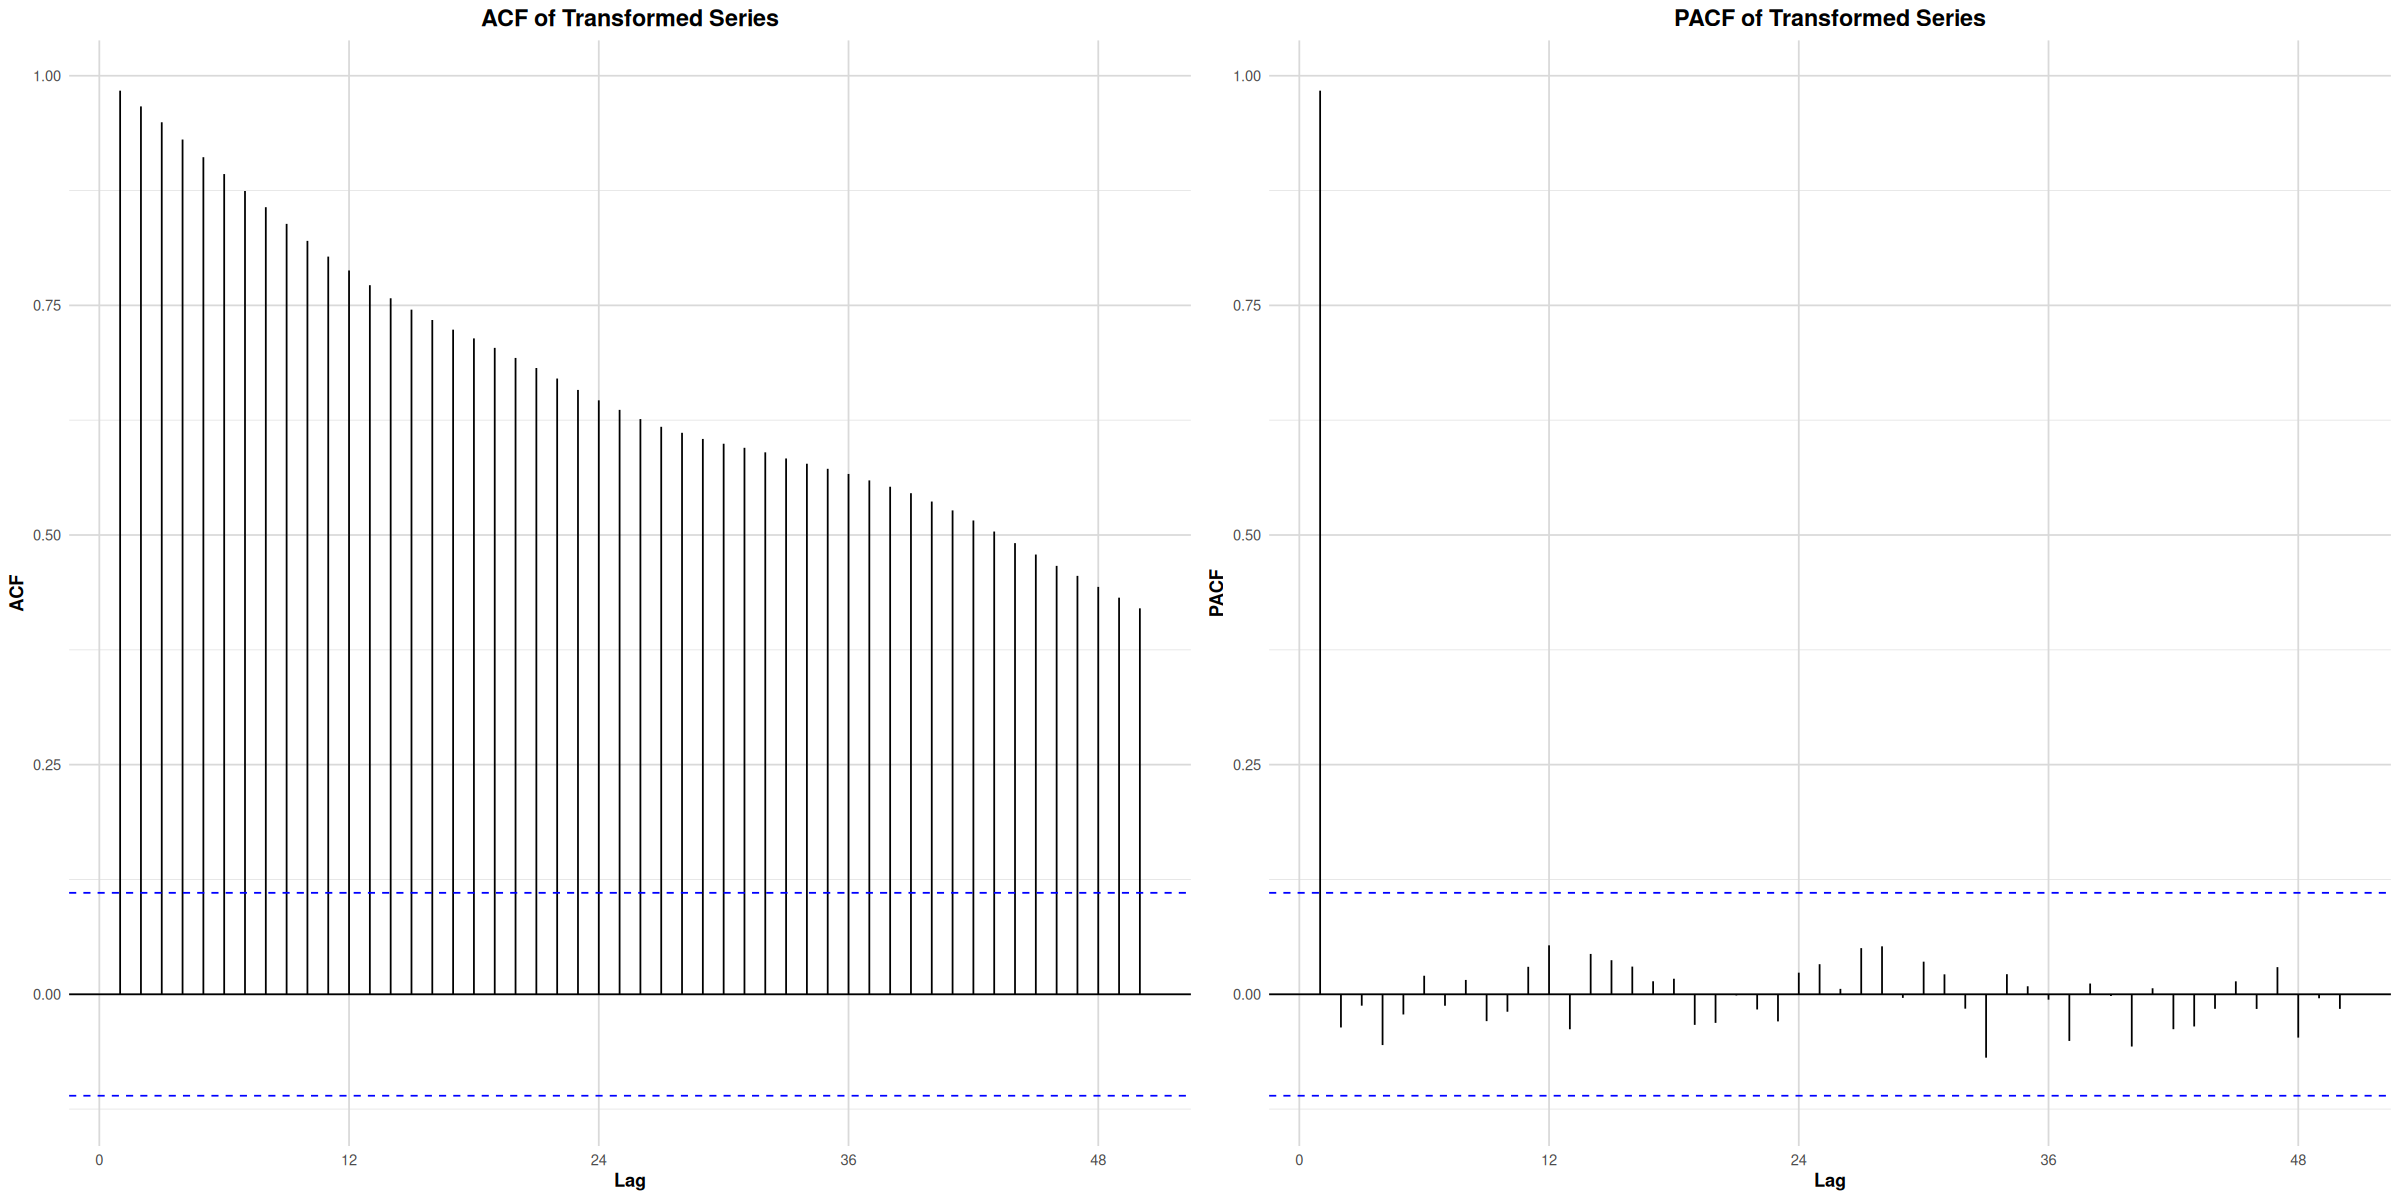

In [10]:
# ACF and PACF plots

p_acf <- ggAcf(transformed_ts, lag = 50) +
  labs(
    title = "ACF of Transformed Series",
    x = "Lag",
    y = "ACF"
  ) +
  theme_tsa()

p_pacf <- ggAcf(transformed_ts, lag = 50, type = "partial") +
    labs(
        title = "PACF of Transformed Series",
        x = "Lag",
        y = "PACF"
    ) +
    theme_tsa()

grid.arrange(p_acf, p_pacf, ncol = 2)

In [11]:
# test for stationarity using ADF test and KPSS test

adf_test <- adf.test(transformed_ts, alternative = "stationary")
kpss_test <- kpss.test(transformed_ts, null = "Trend")

cat("ADF Test for Stationarity:\n")
print(adf_test)

cat("\nKPSS Test for Stationarity:\n")
print(kpss_test)

cat("\nConclusion:\n")
if (adf_test$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in kpss.test(transformed_ts, null = "Trend"):
“p-value smaller than printed p-value”


ADF Test for Stationarity:

	Augmented Dickey-Fuller Test

data:  transformed_ts
Dickey-Fuller = -1.5828, Lag order = 6, p-value = 0.7523
alternative hypothesis: stationary


KPSS Test for Stationarity:

	KPSS Test for Trend Stationarity

data:  transformed_ts
KPSS Trend = 0.94871, Truncation lag parameter = 5, p-value = 0.01


Conclusion:
ADF test fails to reject the null hypothesis, series is non-stationary
KPSS test rejects the null hypothesis, series is non-stationary


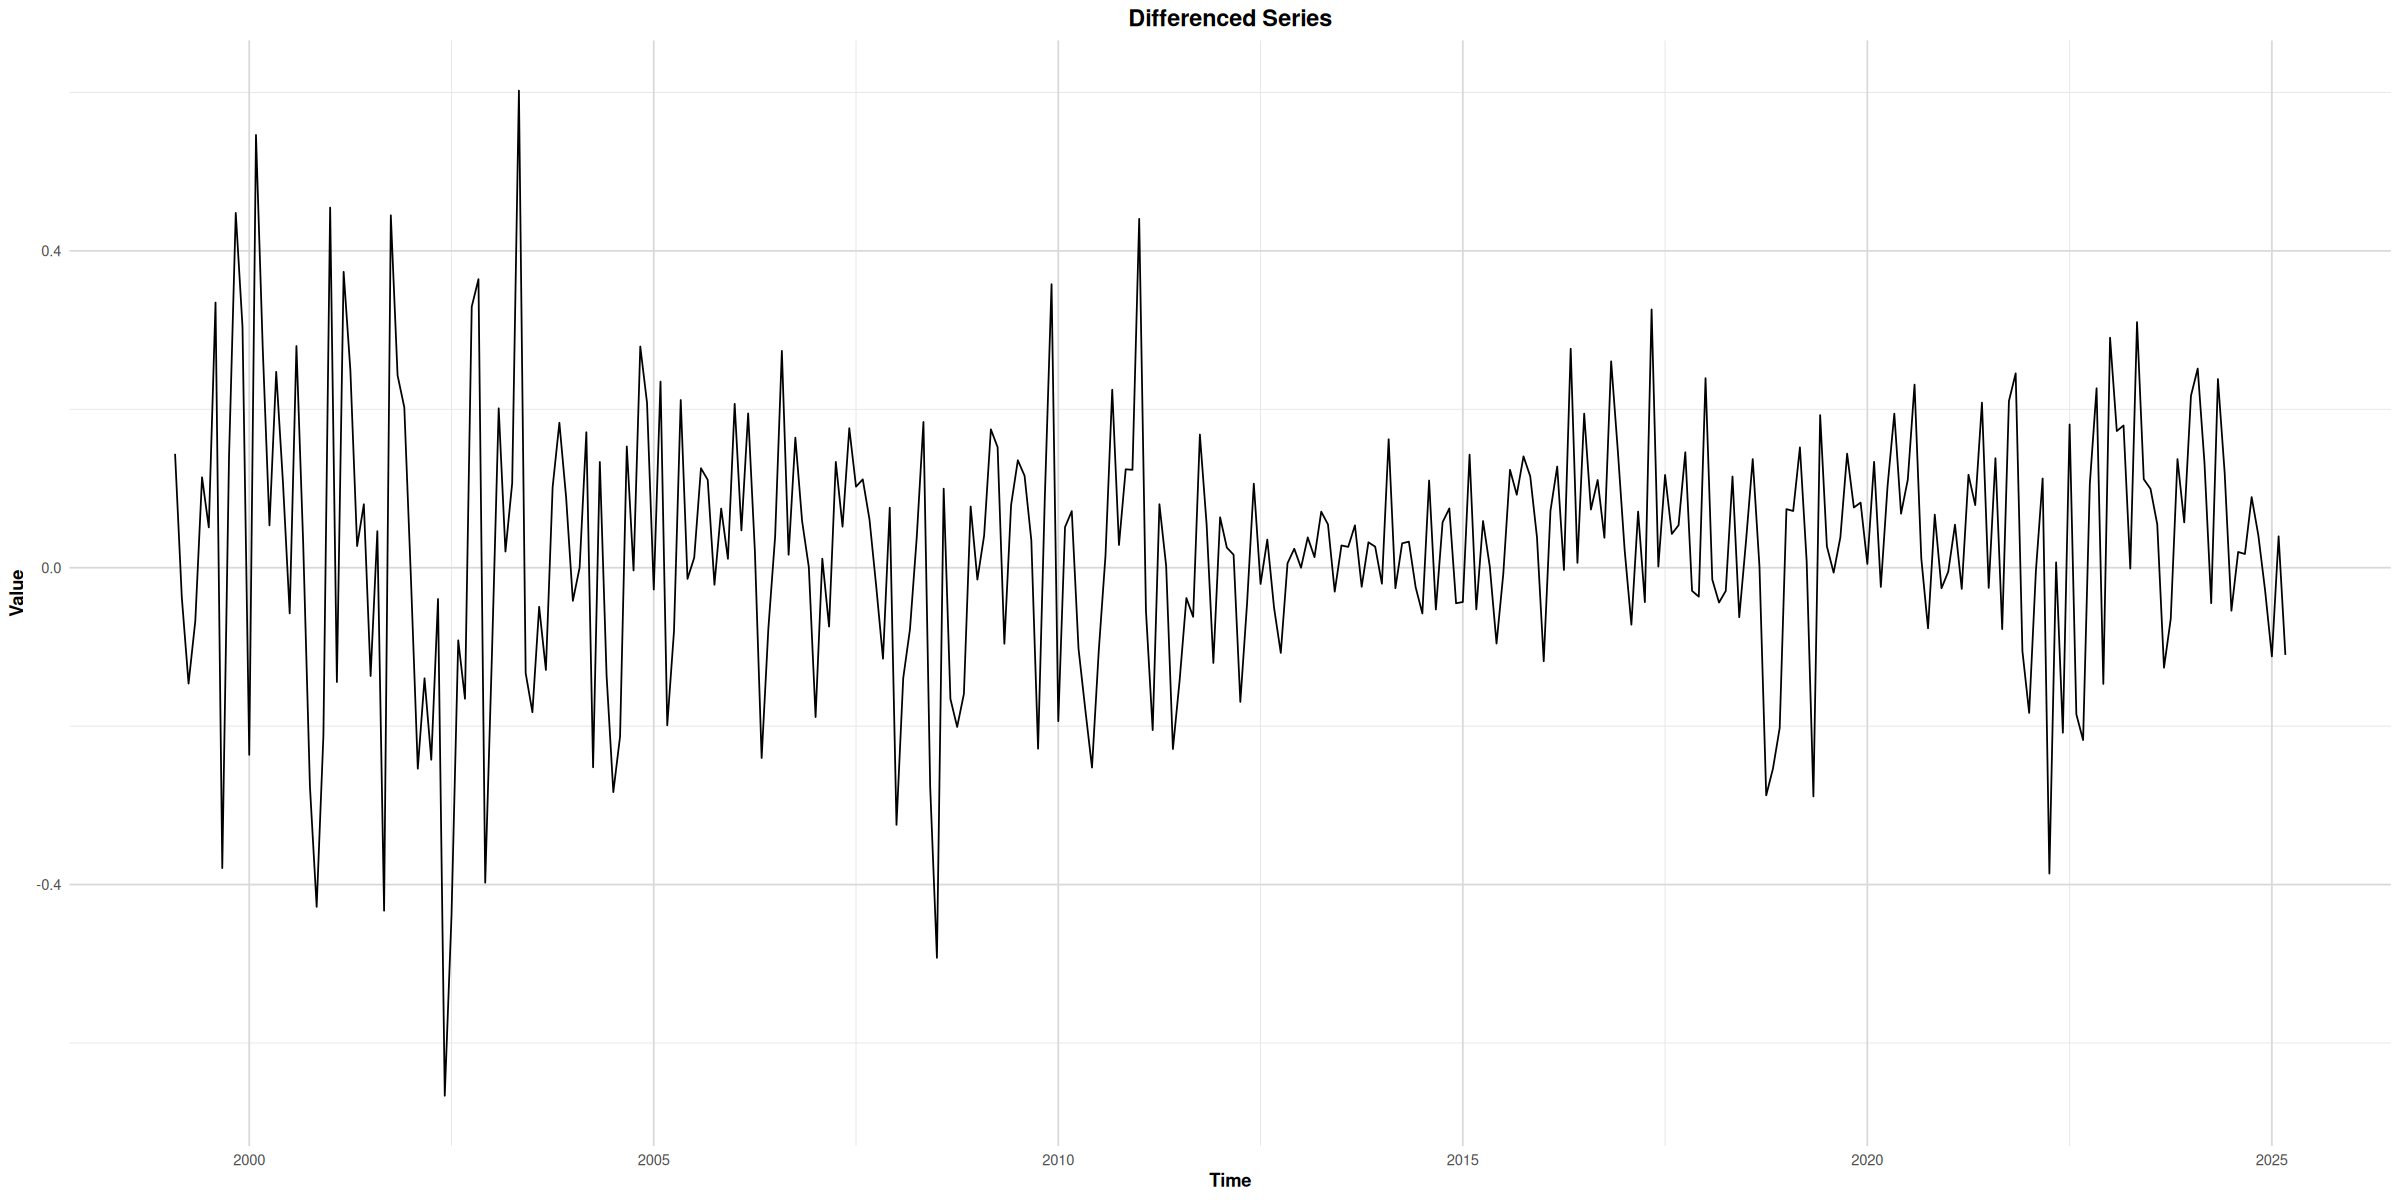

In [12]:
# differencing the series to make it stationary

diff_ts <- diff(transformed_ts)

p_diff <- autoplot(diff_ts) +
    labs(
        title = "Differenced Series",
        x = "Time", y = "Value"
    ) +
    theme_tsa()

print(p_diff)

In [13]:
# retesting for stationarity after differencing

adf_test_diff <- adf.test(diff_ts, alternative = "stationary")
kpss_test_diff <- kpss.test(diff_ts, null = "Trend")

cat("ADF Test for Stationarity (After Differencing):\n")
print(adf_test_diff)

cat("\nKPSS Test for Stationarity (After Differencing):\n")
print(kpss_test_diff)

cat("\nConclusion (After Differencing):\n")
if (adf_test_diff$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test_diff$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in adf.test(diff_ts, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in kpss.test(diff_ts, null = "Trend"):
“p-value greater than printed p-value”


ADF Test for Stationarity (After Differencing):

	Augmented Dickey-Fuller Test

data:  diff_ts
Dickey-Fuller = -6.4685, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


KPSS Test for Stationarity (After Differencing):

	KPSS Test for Trend Stationarity

data:  diff_ts
KPSS Trend = 0.06528, Truncation lag parameter = 5, p-value = 0.1


Conclusion (After Differencing):
ADF test rejects the null hypothesis, series is stationary
KPSS test fails to reject the null hypothesis, series is stationary


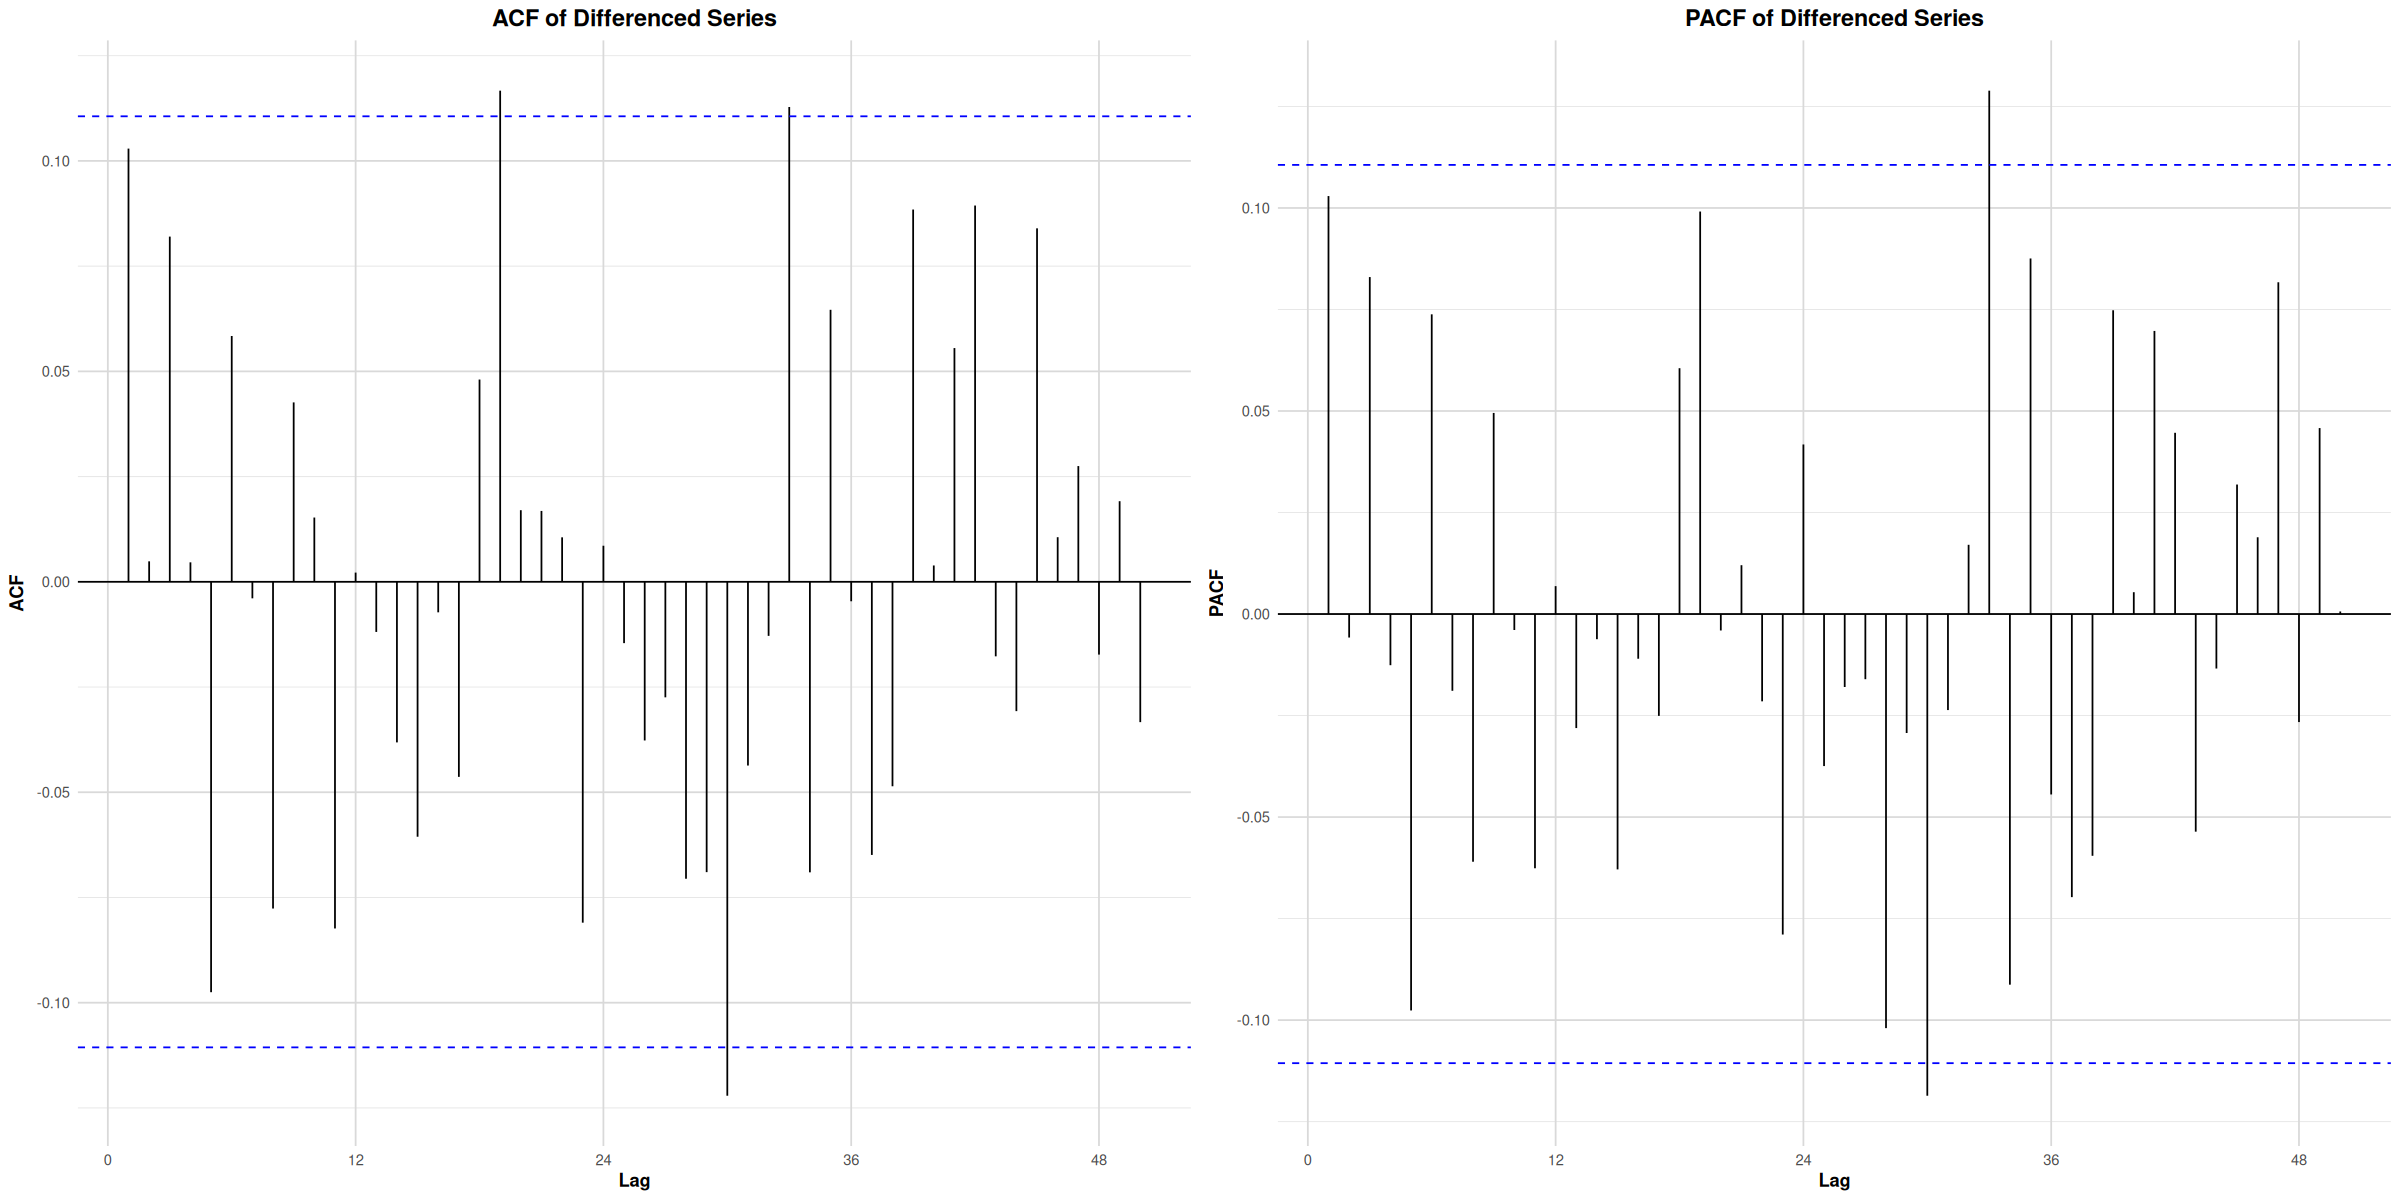

In [14]:
# ACF and PACF plots for differenced series
p_acf_diff <- ggAcf(diff_ts, lag = 50) +
    labs(
        title = "ACF of Differenced Series",
        x = "Lag", y = "ACF"
    ) +
    theme_tsa()

p_pacf_diff <- ggAcf(diff_ts, lag = 50, type = "partial") +
    labs(
        title = "PACF of Differenced Series",
        x = "Lag", y = "PACF"
    ) +
    theme_tsa()

grid.arrange(p_acf_diff, p_pacf_diff, ncol = 2)

In [28]:
subset_results <- armasubsets(y = diff_ts, nar = 10, nma = 10,
                              ar.method = "ols")

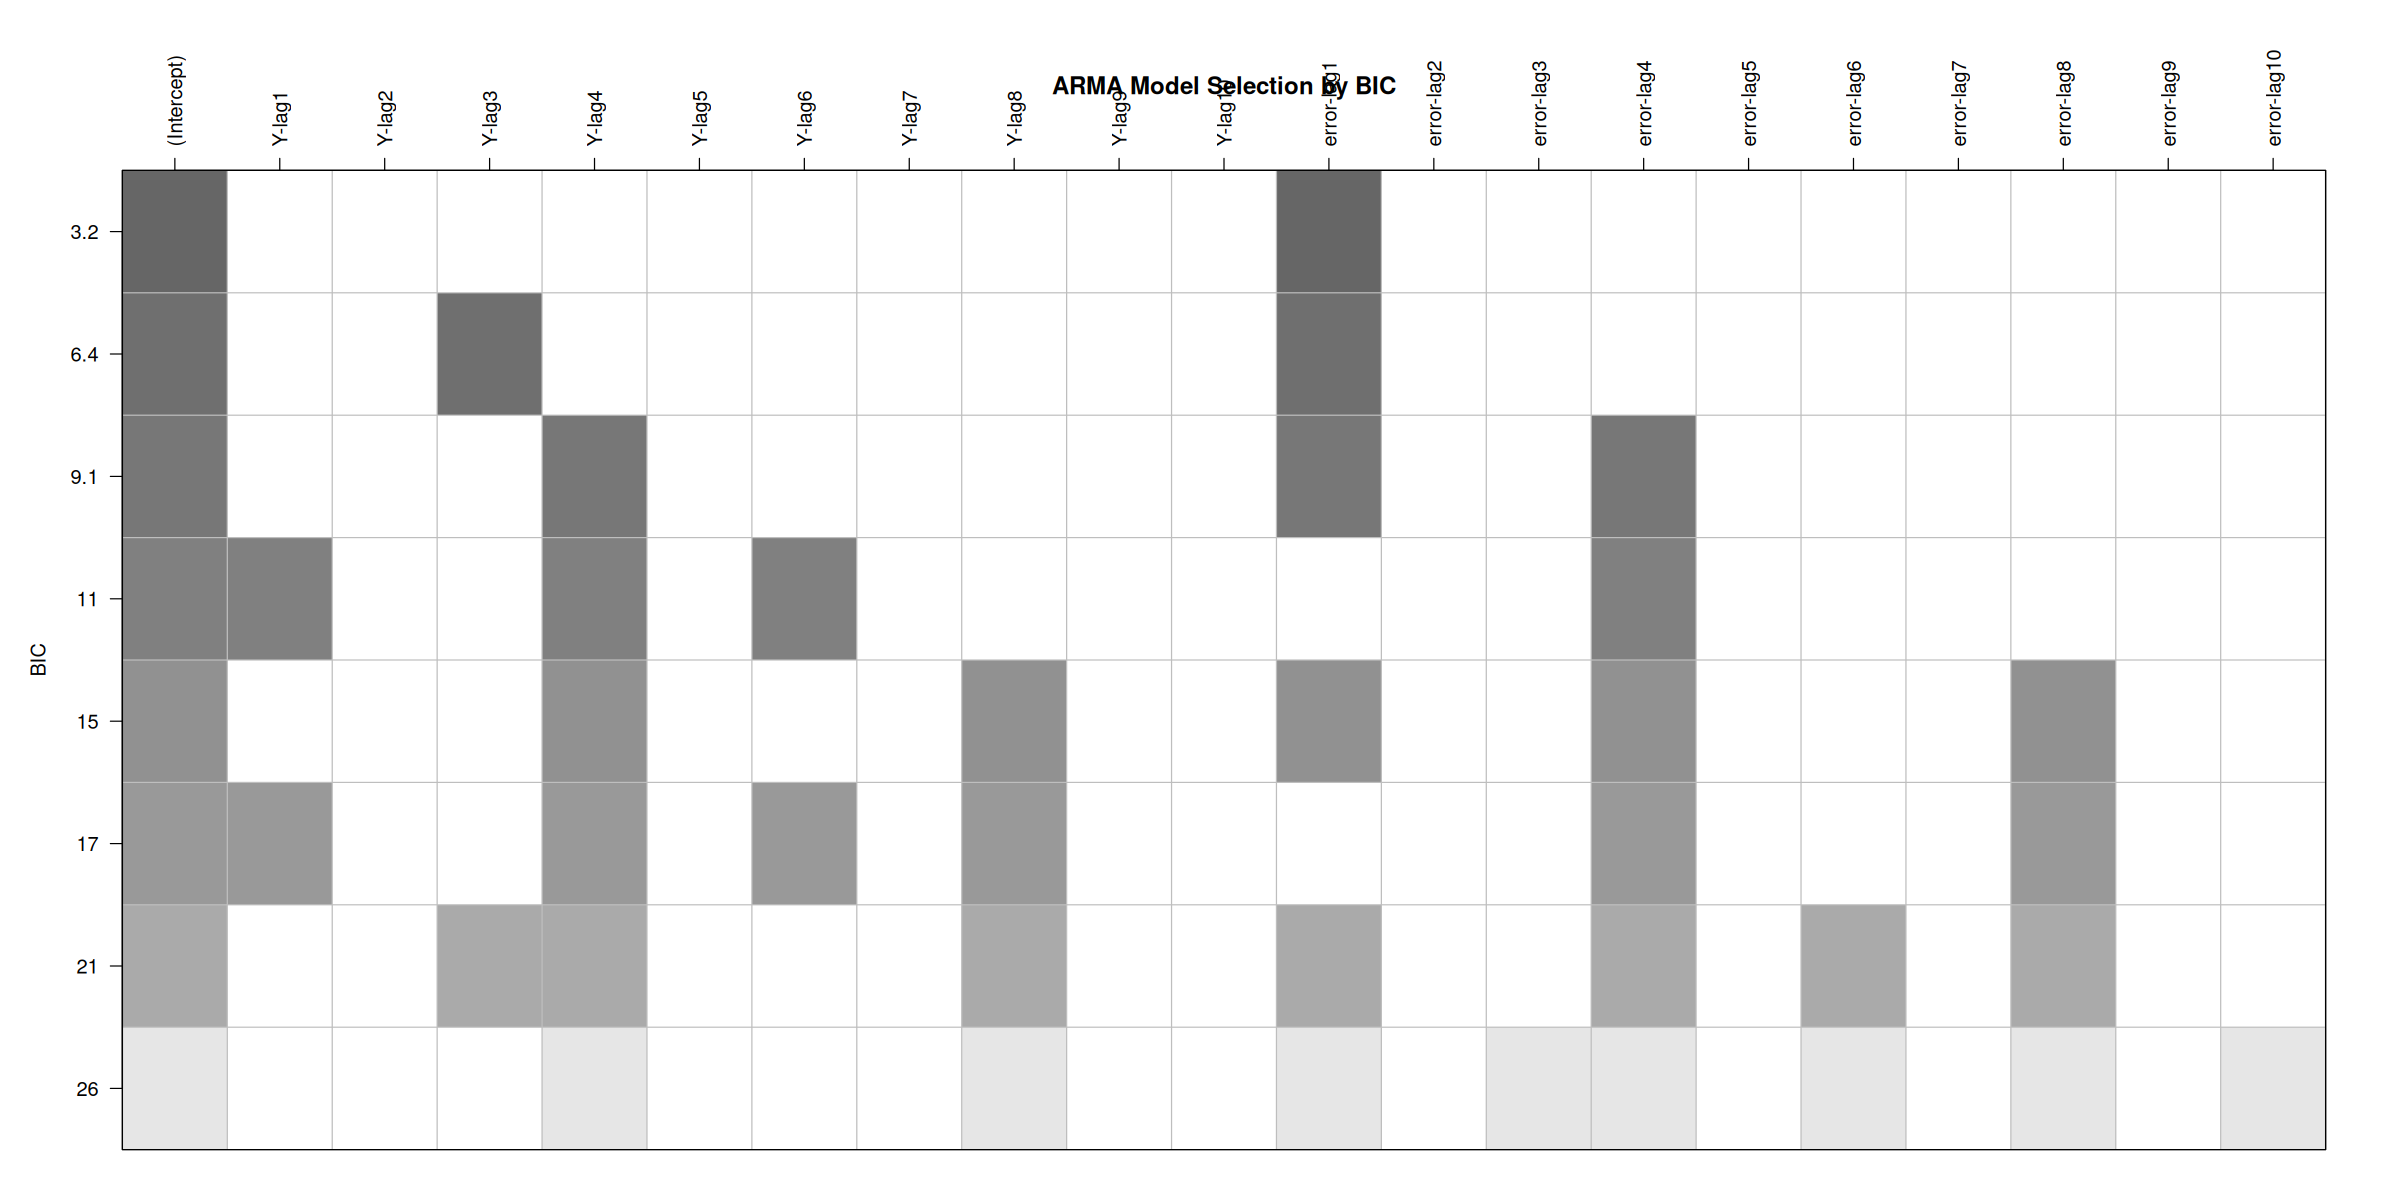

In [34]:
par(bg = "white")
plot(subset_results, which = "bic", main = "ARMA Model Selection by BIC",
     xlab = "AR and MA terms", ylab = "BIC", cex.axis = 1, cex.lab = 1)

We can clearly observe that the best model is ARIMA(0,1,1), then ARIMA(3,1,1) and ARIMA(4,1,4)